<a href="https://colab.research.google.com/github/raulbenitez/IWANN2021_DL_tutorial/blob/main/deep_MNIST_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Introduction to Deep Learning
IWANN 2021 Tutorial

---

Raul Benitez, PhD

Universitat Politècnica de Catalunya

contact: raul.benitez@upc.edu

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
folder_data = '/content/drive/MyDrive/IWANN_course_data'
load_data = 'True' #Set to 'True' to load data and avoid time consuming executions

# Part 1: MNIST data exploration

## Load MNIST data

In [12]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Load data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Visualize image dataset 

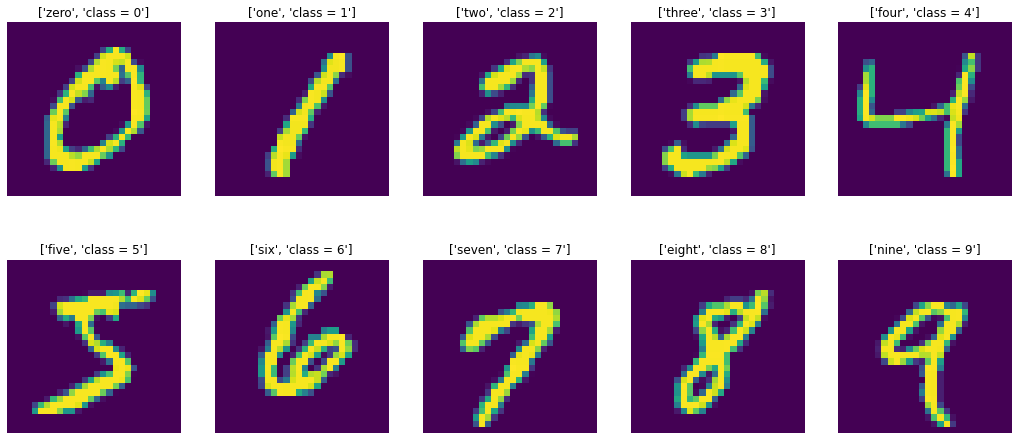

In [13]:
import skimage as sk # load skimage libraries
from skimage import io
import matplotlib.pylab as plt

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

fig = plt.figure(figsize=(18, 8))

for kclass in range(0,10):
    ind = np.argwhere(y_train==kclass)
    ax = fig.add_subplot(2, 5, kclass+1)
    ax.imshow(x_train[ind[0][0]].squeeze())
    ax.set_title([label_names[kclass], 'class = {}'.format(kclass)])
    ax.axis('off')

## Low-dimension projections of the MNIST test data subset

## 2D PCA projection

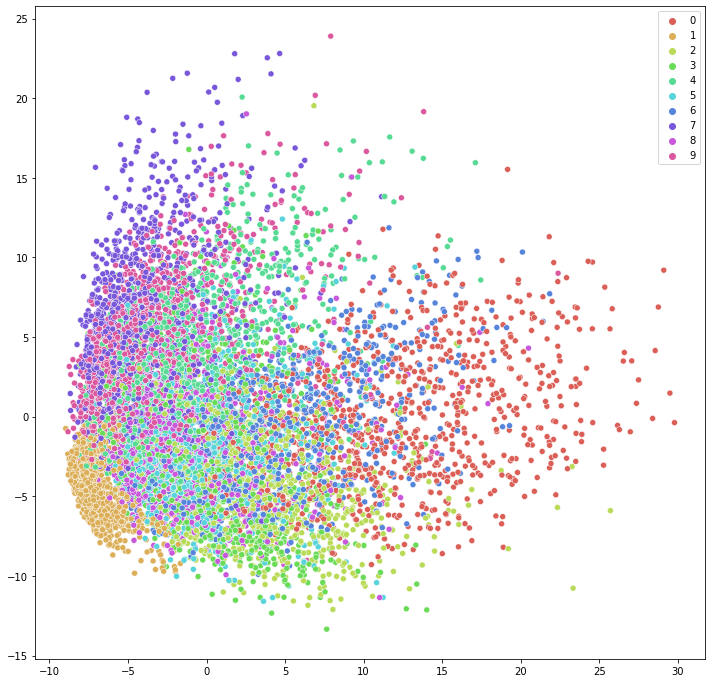

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Reshape datasets as NOBSERVATIONS x NPIXELS (Flatten):
train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

# Scale (Standardization)
train = StandardScaler().fit_transform(train)
test = StandardScaler().fit_transform(test)

# PROJECT TO A 2D PCA SPACE:
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(test)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = pca_proj[:,0], y = pca_proj[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full')

In [15]:
print('The size of flattened training data is {}'.format(train.shape))
print('The size of flattened test data is {}'.format(test.shape))
print('The size of the 2D PCA projection of the test data is {}'.format(pca_proj.shape))

The size of flattened training data is (60000, 784)
The size of flattened test data is (10000, 784)
The size of the 2D PCA projection of the test data is (10000, 2)


No surprise that all classes are entangled in the 2d PCA projection since the variance explained by a 2D PCA projection is only a fraction of the total variability:

In [16]:
pca.explained_variance_ratio_.cumsum()

array([0.06196854, 0.10440621], dtype=float32)

## T-SNE projection 

Visualizing high-dimensional data by projecting it into a low-dimensional space

https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf



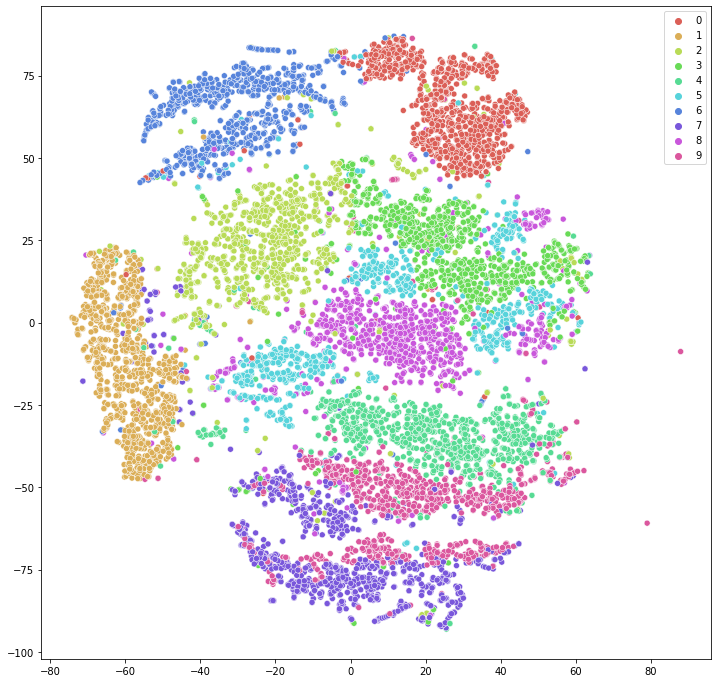

In [17]:
from sklearn.manifold import TSNE

if load_data == 'False':
  tsne = TSNE(n_components = 2, random_state=0)
  tsne_res = tsne.fit_transform(test)
else:
  data = np.load(folder_data+'/tsne.npz')
  tsne_res = data['arr_1']

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

## PCA + t-SNE

Let's first project into a PCA space explaining 95% of the variability and then visualize the PCA projection using a 2D t-SNE manifold

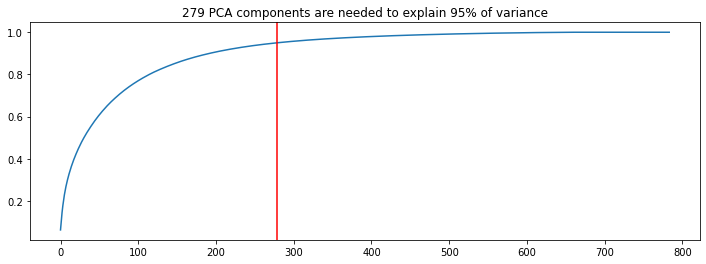

In [18]:
pca_full = PCA(n_components=test.shape[1])
pca_full.fit(test)

cummulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Find number of components needed to explain 95% of variance:
ind= np.argwhere(cummulative_variance>0.95)
Ncomponents_95 = ind[0].item()

fig = plt.figure(figsize=(12,4))
plt.plot(cummulative_variance)
plt.axvline(Ncomponents_95,c='r')
plt.title('{} PCA components are needed to explain 95% of variance'.format(Ncomponents_95))
plt.show()

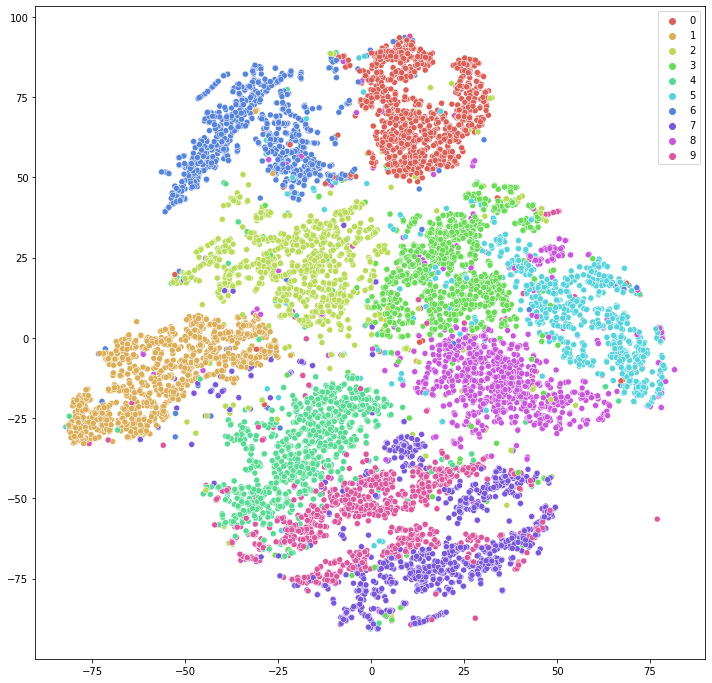

In [19]:
pca95 = PCA(n_components=Ncomponents_95)
pca95_proj = pca95.fit_transform(test)

if load_data == 'False':
  tsne = TSNE(n_components = 2, random_state=0)
  tsne_pca = tsne.fit_transform(pca95_proj)
  np.savez(folder_data+'/tsne.npz', tsne_pca,tsne_res)
else:
  data = np.load(folder_data+'/tsne.npz')
  tsne_pca = data['arr_0']

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_pca[:,0], y = tsne_pca[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

PCA as feature extraction works pretty well (eigenfaces)

## Clustering - unsupervised approach
In this section we apply an unsupervised clustering approach to identfy each cluster in the feature space. In particular, we apply a Gaussian Mixture Model with model selection using the Bayesian Information Criterion parsimony index.


[203909.00391066918]
[203909.00391066918, 202148.28057461235]
[203909.00391066918, 202148.28057461235, 201123.74947769684]
[203909.00391066918, 202148.28057461235, 201123.74947769684, 199389.2728887063]
[203909.00391066918, 202148.28057461235, 201123.74947769684, 199389.2728887063, 199086.47449996884]
[203909.00391066918, 202148.28057461235, 201123.74947769684, 199389.2728887063, 199086.47449996884, 198736.50975824302]
[203909.00391066918, 202148.28057461235, 201123.74947769684, 199389.2728887063, 199086.47449996884, 198736.50975824302, 198140.75251965754]
[203909.00391066918, 202148.28057461235, 201123.74947769684, 199389.2728887063, 199086.47449996884, 198736.50975824302, 198140.75251965754, 197961.82812577373]
[203909.00391066918, 202148.28057461235, 201123.74947769684, 199389.2728887063, 199086.47449996884, 198736.50975824302, 198140.75251965754, 197961.82812577373, 198005.72637398483]
[203909.00391066918, 202148.28057461235, 201123.74947769684, 199389.2728887063, 199086.4744999688

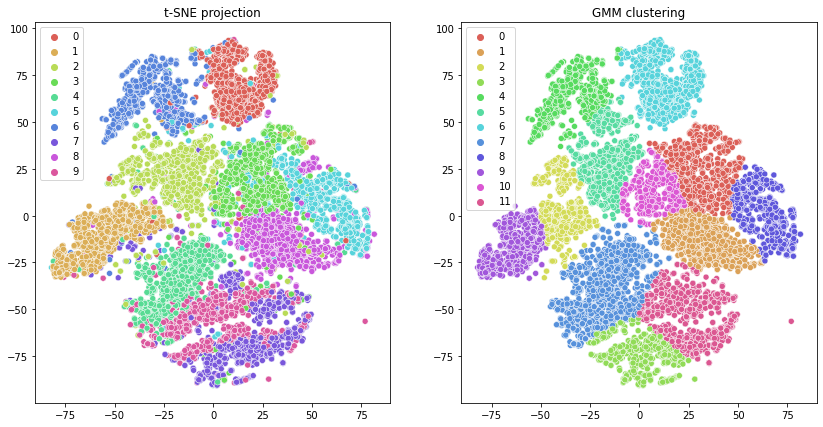

In [20]:
from sklearn import mixture

X = tsne_pca[:,0:2]

NMAX = 12
bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(X)
    bic.append(gmm.bic(X))
    print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))
gmm = mixture.GaussianMixture(n_components=idx_winner+1,covariance_type='full').fit(X)
y_pred_gmm = gmm.fit_predict(X)


plt.figure(figsize=(14,7))

ax0 = plt.subplot(1,2,1)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');
plt.title("t-SNE projection")

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y_pred_gmm, palette = sns.hls_palette(idx_winner+1));
plt.title("GMM clustering")
plt.show()

Some digits can be easily identified as an isolated cluster, others are identified as two subgroups. We also observe that two different digits are grouped together as a single cluster. 

## UMAP Projection


UMAP is a flexible non-linear dimension reduction algorithm that learns the manifold structure of your data and find a low dimensional embedding that preserves its topological structure.

https://arxiv.org/abs/1802.03426

https://umap-learn.readthedocs.io/en/latest/

First, install UMAP library in google colab platform

In [21]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 34.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=b379b11f0470c3f46f4b847ce1274dcee1b09a19f01fccaaf12b643e506e5c60
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=81e1eff7f4d85a3ecf2f904a22de3164c582e1514878e3ede2b81c8b7e224254
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [31]:
import umap
import pickle
load_data = 'True'
if load_data == 'False':
  mapper = umap.UMAP().fit(test) # create the UMAP mapper
  embedding = mapper.transform(test) # project data 
  np.savez(folder_data+'/umap.npz', embedding)
  pickle.dump(mapper, open(folder_data+'/umap_mapper.sav', 'wb'))
else: 
  data = np.load(folder_data+'/umap.npz')
  embedding = data['arr_0']
  mapper = pickle.load(open(folder_data+'/umap_mapper.sav', 'rb'))

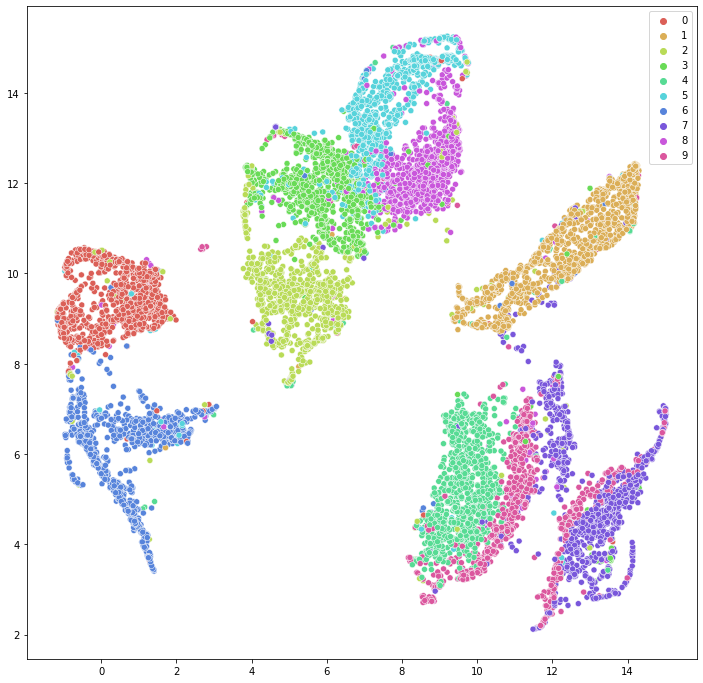

In [32]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = embedding[:,0], y = embedding[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

Visualize the projected data using the inverse UMAP projection on a grid

In [33]:
corners = np.array([
    [0, 2],  # bottom left corner
    [15, 2],  # bottom right
    [0, 15],  # top left
    [15, 15],  # top right
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

In [34]:
inv_transformed_points = mapper.inverse_transform(test_pts)

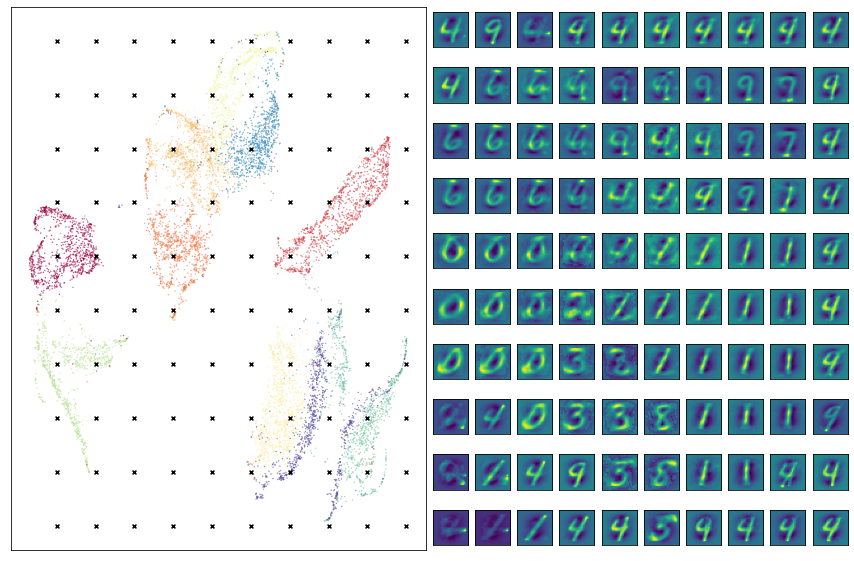

In [35]:
from matplotlib.gridspec import GridSpec

# Set up the grid
fig = plt.figure(figsize=(15,10))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],
                   c=y_test.astype(np.int32), cmap='Spectral', s=0.1)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(28, 28))
        digit_axes[i, j].set(xticks=[], yticks=[])

# Part 2: The Traditional Machine Learning approach



## Fit a KNN classifier using raw data

              precision    recall  f1-score   support

        zero       0.92      0.99      0.95       980
         one       0.94      1.00      0.97      1135
         two       0.93      0.94      0.93      1032
       three       0.90      0.95      0.92      1010
        four       0.92      0.96      0.94       982
        five       0.91      0.90      0.91       892
         six       0.98      0.94      0.96       958
       seven       0.91      0.93      0.92      1028
       eight       0.98      0.85      0.91       974
        nine       0.97      0.86      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



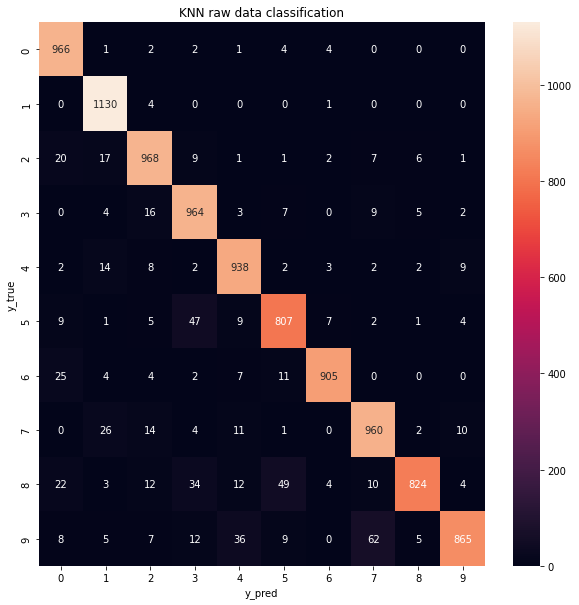

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

if load_data == 'False':
  knn_raw = KNeighborsClassifier(n_neighbors=2) # load the model
  knn_raw.fit(train,y_train) # fit the model using training data
  y_test_pred_raw = knn_raw.predict(test) # model prediction of test data

  pickle.dump(knn_raw, open(folder_data+'/knn_raw_model.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred_raw.npz', y_test_pred_raw)

else:
  knn_raw = pickle.load(open(folder_data+'/knn_raw_model.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred_raw.npz')
  y_test_pred_raw = data['arr_0']

cm_raw = confusion_matrix(y_test, y_test_pred_raw)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_raw,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN raw data classification')

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
print(classification_report(y_test, y_test_pred_raw, target_names=label_names))

## Fit a kNN classifier using PCA features: eigenfaces

Use PCA to extract features from the images and classify them using a KNN  algorithm. Keep as many PCA components as needed to explain 95% of the variance in the training set.

In [39]:
# GET PCA FEATURES PROJECTING TO THE PCA SPACE:
pca_train = pca95.fit_transform(train)
pca_test = pca95.fit_transform(test)

print('Number of PCA components needed to explain 95% of variability is {}'.format(Ncomponents_95))
print('The PCA training set has dimensions {} {}'.format(*pca_train.shape))
print('The PCA test set has dimensions {} {}'.format(*pca_test.shape))

Number of PCA components needed to explain 95% of variability is 279
The PCA training set has dimensions 60000 279
The PCA test set has dimensions 10000 279


In [46]:
from sklearn.neighbors import KNeighborsClassifier

if load_data == 'False':
  knn = KNeighborsClassifier(n_neighbors=2) # load the model
  knn.fit(pca_train,y_train) # fit the model using training data
  y_test_pred = knn.predict(pca_test) # model prediction of test data

  pickle.dump(knn, open(folder_data+'/knn_pca_model.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred.npz', y_test_pred)

else:
  knn = pickle.load(open(folder_data+'/knn_pca_model.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred.npz')
  y_test_pred = data['arr_0']


Text(0.5, 1.0, 'KNN pca features classification')

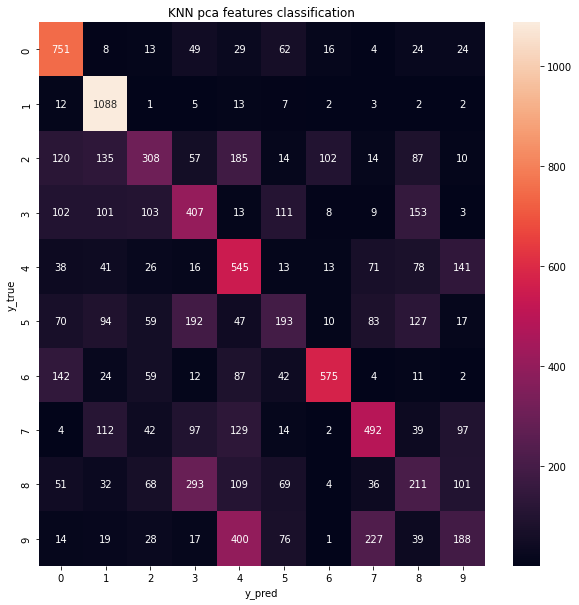

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN pca features classification')

In [48]:
print(classification_report(y_test, y_test_pred, target_names=label_names))

              precision    recall  f1-score   support

        zero       0.58      0.77      0.66       980
         one       0.66      0.96      0.78      1135
         two       0.44      0.30      0.35      1032
       three       0.36      0.40      0.38      1010
        four       0.35      0.55      0.43       982
        five       0.32      0.22      0.26       892
         six       0.78      0.60      0.68       958
       seven       0.52      0.48      0.50      1028
       eight       0.27      0.22      0.24       974
        nine       0.32      0.19      0.24      1009

    accuracy                           0.48     10000
   macro avg       0.46      0.47      0.45     10000
weighted avg       0.46      0.48      0.46     10000



Traditional features do not always represent the full complexity of the classification problem

# Part 3: The DL approach

## Classification using pre-trained Deep Features: Transfer Learning

Use a pre-trained CNN architecture to extract deep features

### Pre-processing data 

Some pre-processing is needed in order to adjust input data to the CNN architecture

Convert training and test subsets in 3-channel images

In [49]:
x_train3 = np.dstack([train] * 3)
x_test3 = np.dstack([test]*3)
x_train3.shape,x_test3.shape

((60000, 784, 3), (10000, 784, 3))

Reshape images images in tensor format required by tensorflow

In [50]:
# Reshape images as per the tensor format required by tensorflow
train_X = x_train3.reshape(-1, 28,28,3)
test_X = x_test3.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

Resize the images 48*48 as required by VGG16 architecture

In [51]:
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

Normalise the data and change data type to float


In [52]:
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

Preprocess the input to fit the architecture


In [53]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_X = preprocess_input(train_X)
test_X  = preprocess_input(test_X)

Instantiate the VGG16 model pre-trained with imagenet database. We load only the layers corresponding to the feature extraction and skip the last fully connected layers for classification (include_top=False). 


In [54]:
from tensorflow.keras.applications.vgg16 import VGG16

# Parameters:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

# model:
model = VGG16(weights='imagenet',include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

### Extract deep features

In [55]:
# Extracting features
if load_data == 'False':
  train_deep_features = model.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
  test_deep_features = model.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
  
  np.savez(folder_data+'/deep_feat.npz', train_deep_features, train_X,test_deep_features, test_X)
else: 
  data = np.load(folder_data+'/deep_feat.npz')
  train_deep_features = data['arr_0']
  train_X = data['arr_1']
  test_deep_features = data['arr_2']
  test_X = data['arr_3']

train_deep_features.shape,test_deep_features.shape

((60000, 1, 1, 512), (10000, 1, 1, 512))

### visualize deep features using UMAP

In [56]:
if load_data == 'False':
  umap_deep = umap.UMAP(n_neighbors=15).fit_transform(test_deep_features.squeeze())
  np.savez(folder_data+'/umap_deep.npz', umap_deep)
else: 
  data = np.load(folder_data+'/umap_deep.npz')
  umap_deep = data['arr_0']

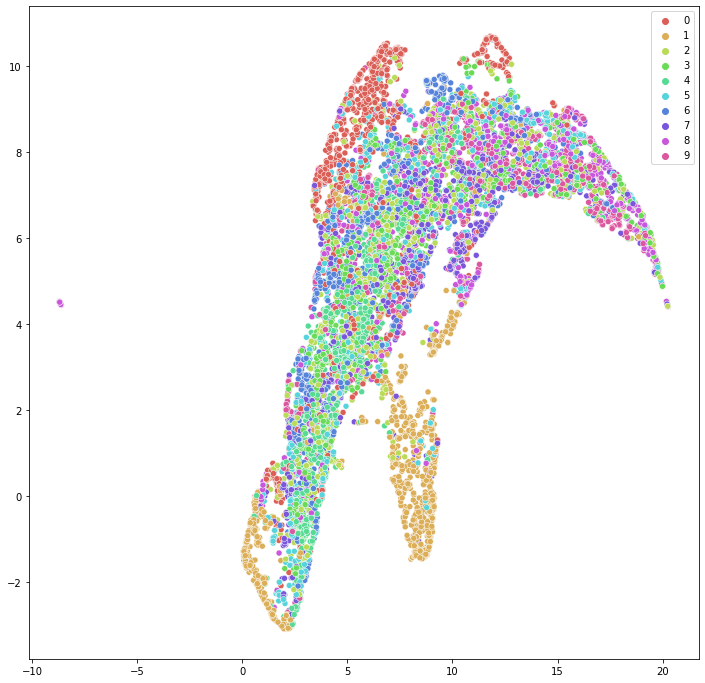

In [57]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_deep[:,0], y = umap_deep[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

### Classify with pre-trained, transfer-learned deep features

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

if load_data == 'False':
  knn_DL_TL = KNeighborsClassifier(n_neighbors=2) # load the model
  knn_DL_TL.fit(train_deep_features.squeeze(),y_train) # fit the model using training data
  y_test_pred_DL_TL = knn_DL_TL.predict(test_deep_features.squeeze()) # model prediction of test data

  pickle.dump(knn_DL_TL, open(folder_data+'/knn_DL_TL.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred_DL_TL.npz', y_test_pred)

else:
  knn_DL_TL = pickle.load(open(folder_data+'/knn_DL_TL.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred_DL_TL.npz')
  y_test_pred_DL_TL = data['arr_0']

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
print(classification_report(y_test, y_test_pred_DL_TL, target_names=label_names))

              precision    recall  f1-score   support

        zero       0.58      0.77      0.66       980
         one       0.66      0.96      0.78      1135
         two       0.44      0.30      0.35      1032
       three       0.36      0.40      0.38      1010
        four       0.35      0.55      0.43       982
        five       0.32      0.22      0.26       892
         six       0.78      0.60      0.68       958
       seven       0.52      0.48      0.50      1028
       eight       0.27      0.22      0.24       974
        nine       0.32      0.19      0.24      1009

    accuracy                           0.48     10000
   macro avg       0.46      0.47      0.45     10000
weighted avg       0.46      0.48      0.46     10000



We see that the overall accuracy of the classifier improves when using deep features instead PCA features

## The fully trained DL model

Both feature extraction and classification are performed using a simple custom-made CNN architecture trained with the MNIST training subset. 
MNIST classification using a simple CNN architecture 

From: https://keras.io/examples/vision/mnist_convnet/


### Build and train

In [61]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [62]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [63]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [64]:
batch_size =256
epochs = 5

if load_data == 'False':
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)
  model.save(folder_data + '/model_saved') # save trained model
else: 
  model = keras.models.load_model(folder_data + '/model_saved')


### Evaluate 

In [66]:
score = model.evaluate(x_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(x_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.04168509691953659
Test accuracy: 0.9876999855041504
              precision    recall  f1-score   support

        zero       0.98      1.00      0.99       980
         one       0.99      1.00      0.99      1135
         two       0.98      0.99      0.99      1032
       three       0.99      0.99      0.99      1010
        four       0.99      0.99      0.99       982
        five       0.99      0.99      0.99       892
         six       0.99      0.99      0.99       958
       seven       0.98      0.98      0.98      1028
       eight       0.99      0.98      0.98       974
        nine       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



MNIST is a solved problem

### Use the trained model for Feature Extraction

Create a new model from the trained one with the features as output 

In [67]:
from tensorflow.keras.models import Model

base_model = keras.models.load_model(folder_data + '/model_saved')

model_FE = Model(inputs=base_model.input, outputs=base_model.get_layer('features').output)
model_FE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 features (Flatten)          (None, 1600)              0     

### Visualize trained features using UMAP

In [68]:
df_test = model_FE.predict(x_test) # extract Deep trained features from text subset

In [69]:
if load_data == 'False':
  umap_df = umap.UMAP(n_neighbors=15).fit_transform(df_test.squeeze())
  np.savez(folder_data+'/umap_df.npz', umap_df)
else: 
  data = np.load(folder_data+'/umap_df.npz')
  umap_df= data['arr_0']


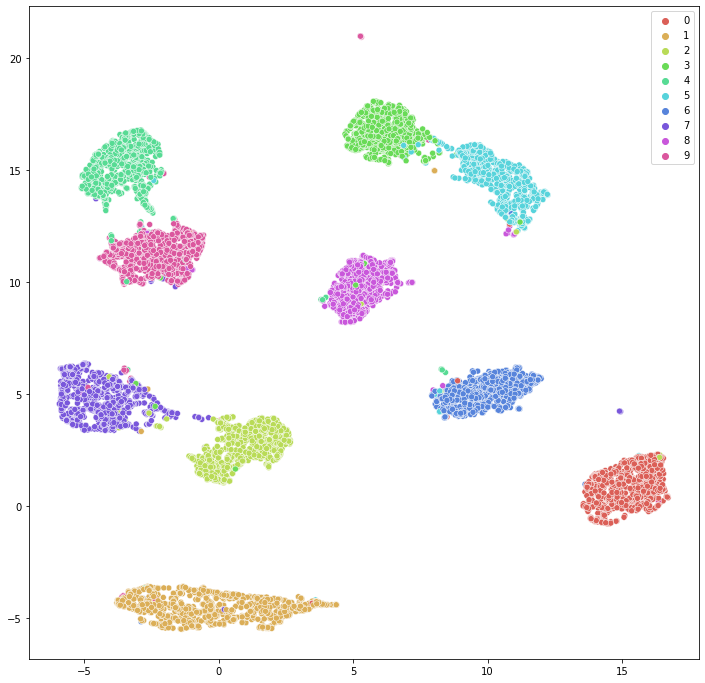

In [70]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

Everything looks much better with trained DL features than in any other scenario. Classifying with such features will provide a high accuracy.

### Classify trained features using KNN

In [74]:
from sklearn.neighbors import KNeighborsClassifier
import pickle 

# extract features from the training subset:
df_train = model_FE.predict(x_train)

if load_data == 'False':
  knn_DL = KNeighborsClassifier(n_neighbors=2) # load the model
  knn_DL.fit(df_train,y_train) # fit the model using training data
  y_test_pred_DL = knn_DL.predict(df_test) # model prediction of test data

  pickle.dump(knn_DL, open(folder_data+'/knn_DL_model.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred_DL.npz', y_test_pred_DL)

else:
  knn_DL = pickle.load(open(folder_data+'/knn_DL_model.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred_DL.npz')
  y_test_pred_DL = data['arr_0']

              precision    recall  f1-score   support

        zero       0.99      1.00      0.99       980
         one       0.98      1.00      0.99      1135
         two       0.98      0.98      0.98      1032
       three       0.98      0.99      0.98      1010
        four       0.98      0.98      0.98       982
        five       0.99      0.98      0.98       892
         six       0.99      0.99      0.99       958
       seven       0.97      0.98      0.98      1028
       eight       0.99      0.97      0.98       974
        nine       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



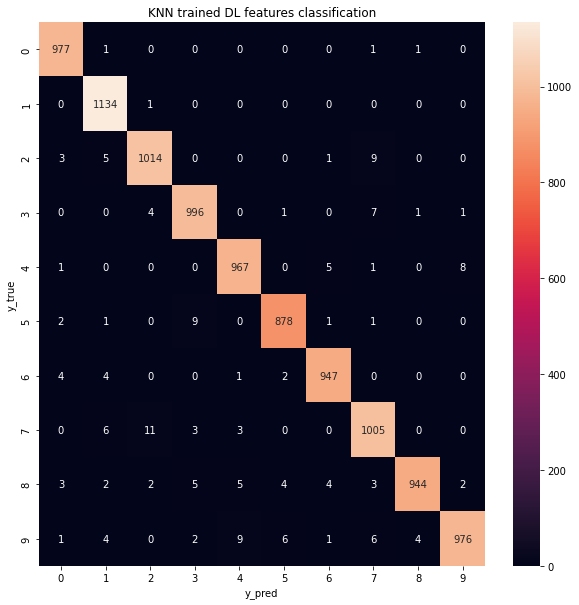

In [75]:
cm_DL = confusion_matrix(y_test, y_test_pred_DL)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_DL,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN trained DL features classification')

print(classification_report(y_test, y_test_pred_DL, target_names=label_names))

# Part 4: DL interpretability

Let's apply some DL interpretability techniques to further understand the DL feature extraction and classification procedure. Let's consider the full DL model architecture

In [76]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 features (Flatten)          (None, 1600)              0         
                                                                 
 dropout_9 (Dropout)         (None, 1600)            

Check dimensions of all convolutional layers in the architecture

In [77]:
for layer in model.layers:
	if 'conv' not in layer.name:
		continue
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_19 (3, 3, 1, 32)
conv2d_20 (3, 3, 32, 64)


## Visualize filters weights

Let's visualize the trained weights of the filters in the first convolutional layer

In [78]:
filters, biases = model.layers[0].get_weights()
from matplotlib import pyplot

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

filters.shape
filters1 = filters.squeeze()

In the first convolutional layer there are 32 filters, each of size 3x3


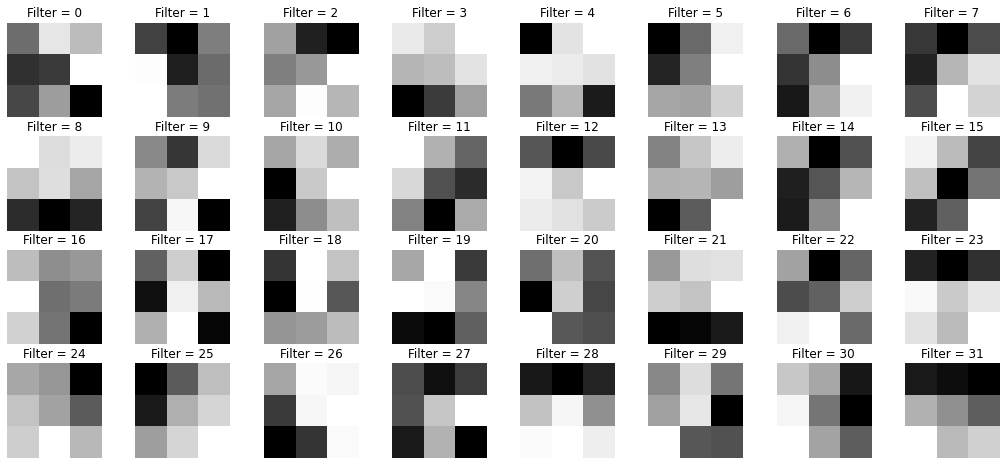

In [79]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
for kfilt in range(0,32):
    ax = fig.add_subplot(4, 8, kfilt+1)
    ax.imshow(filters1[:,:,kfilt], cmap='gray') 
    ax.set_title('Filter = {}'.format(kfilt))
    ax.axis('off')

## Vizualize the feature maps 

Feature maps are the result of projecting an input image across the different convolutional filters in the convolutional layers of the CNN.

In [80]:
from tensorflow.keras.models import Model

# define a new model with outputs the first layer
model_feat_layer0  = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_feat_layer0.summary()

# extract the features provided by the model of the test input
feat_test_layer0 = model_feat_layer0.predict(x_test)

print('layer 0 shape {}'.format(feat_test_layer0.shape))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
layer 0 shape (10000, 26, 26, 32)


plot the feature maps corresponding to the first image in the test subset, which in this case corresponds to a

In [81]:
y_test[0]

7

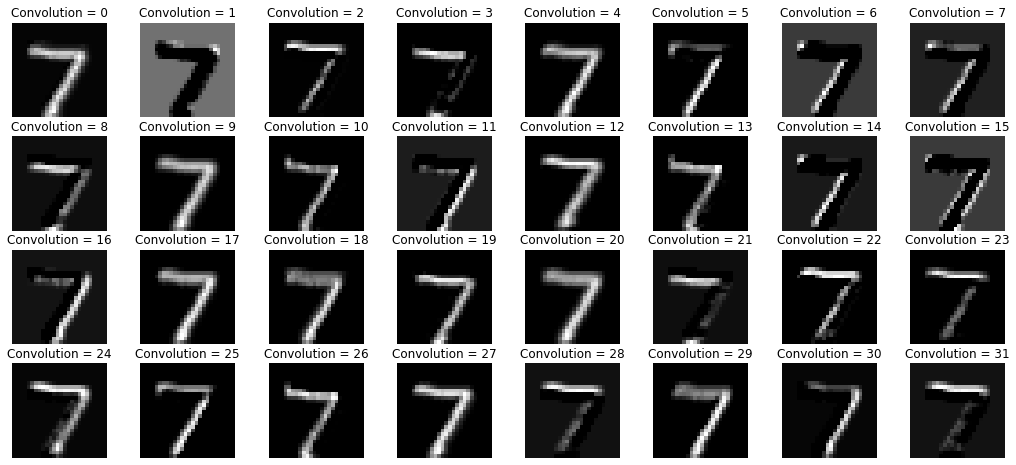

In [82]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
for kfeat in range(0,32):
    ax = fig.add_subplot(4, 8, kfeat+1)
    ax.imshow(feat_test_layer0[0,:,:,kfeat], cmap='gray') 
    ax.set_title('Convolution = {}'.format(kfeat))
    ax.axis('off')

## Activation Maximization

https://raghakot.github.io/keras-vis/visualizations/activation_maximization/

Generate an input image that maximizes the filter output activations. i.e., we compute

$\frac{\partial ActivationMaximizationLoss}{\partial input}$ 

and use that estimate to update the input. ActivationMaximization loss simply outputs small values for large filter activations (we are minimizing losses during gradient descent iterations). This allows us to understand what sort of input patterns activate a particular filter. For example, there could be an eye filter that activates for the presence of eye within the input image.

In [83]:
!pip install tf-keras-vis

     |████████████████████████████████| 53 kB 1.5 MB/s 


Change final activation layer from softmax to linear.
To compute the gradients, it is recommended to change the softmax activation function by
a linear function, since with the softmax the maximization of a class can be achieved by
minimising the scores of the other classes, and using a linear function we ensure that the
optimization concentrates only on the class in question.

In [84]:
from tf_keras_vis.activation_maximization import ActivationMaximization
import tensorflow as tf

def model_modifier(current_model):
    current_model.layers[-1].activation = tf.keras.activations.linear
    return current_model

activation_maximization = ActivationMaximization(model,model_modifier,clone=False)

Score function to maximize a certain category

In [85]:
from tf_keras_vis.utils.scores import CategoricalScore

class_score = 9
score = CategoricalScore(class_score)

In [86]:
from tf_keras_vis.activation_maximization.callbacks import PrintLogger as Logger
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D

# Generate maximized activation
activations = activation_maximization(score,callbacks=[Logger(interval=50)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  """


Steps: 050	Scores: [[-58.66331481933594]],	Regularization: [('TotalVariation2D', [24.435710906982422]), ('Norm', [33.035762786865234])]
Steps: 100	Scores: [[-374.08135986328125]],	Regularization: [('TotalVariation2D', [12.324983596801758]), ('Norm', [29.811288833618164])]
Steps: 150	Scores: [[-424.9501647949219]],	Regularization: [('TotalVariation2D', [8.468059539794922]), ('Norm', [26.705968856811523])]
Steps: 200	Scores: [[-269.2047119140625]],	Regularization: [('TotalVariation2D', [8.819816589355469]), ('Norm', [24.094989776611328])]


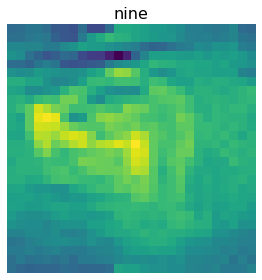

In [87]:
# Visualize 
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations.squeeze())
ax.set_title(class_names[class_score], fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

Let's do the same procedure with all the other digits:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  """


Steps: 050	Scores: [[625.531494140625]],	Regularization: [('TotalVariation2D', [23.572364807128906]), ('Norm', [36.541282653808594])]
Steps: 100	Scores: [[443.4589538574219]],	Regularization: [('TotalVariation2D', [19.842424392700195]), ('Norm', [35.6766471862793])]
Steps: 150	Scores: [[263.9615173339844]],	Regularization: [('TotalVariation2D', [11.719477653503418]), ('Norm', [34.694698333740234])]
Steps: 200	Scores: [[240.5170440673828]],	Regularization: [('TotalVariation2D', [11.321097373962402]), ('Norm', [34.644569396972656])]
Steps: 050	Scores: [[270.83465576171875]],	Regularization: [('TotalVariation2D', [15.34855842590332]), ('Norm', [31.451229095458984])]
Steps: 100	Scores: [[-131.53964233398438]],	Regularization: [('TotalVariation2D', [14.963333129882812]), ('Norm', [29.413293838500977])]
Steps: 150	Scores: [[326.1058654785156]],	Regularization: [('TotalVariation2D', [11.83508586883545]), ('Norm', [26.918489456176758])]
Steps: 200	Scores: [[453.66461181640625]],	Regularization

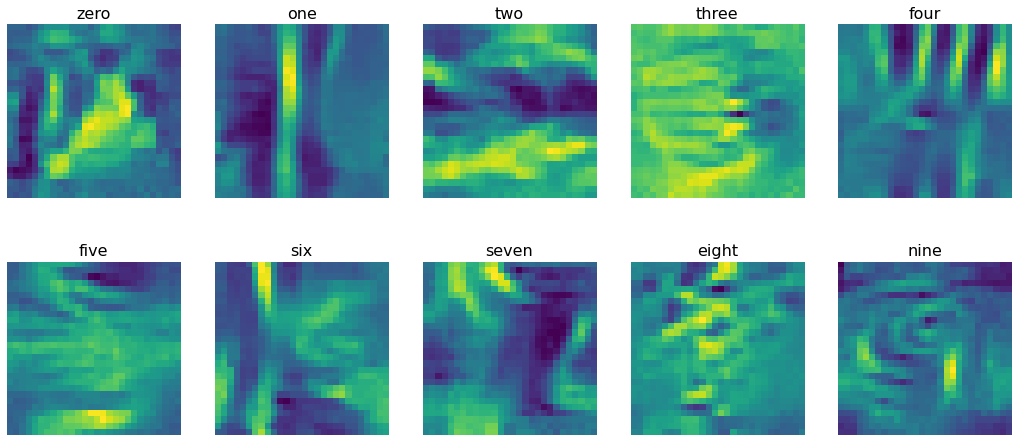

In [88]:
fig = plt.figure(figsize=(18, 8))
for kclass in range(0,10):
    score = CategoricalScore(kclass)
    activation_maximization = ActivationMaximization(model,model_modifier,clone=False)
    activations = activation_maximization(score,callbacks=[Logger(interval=50)])
    ax = fig.add_subplot(2, 5, kclass+1)
    ax.imshow(activations.squeeze())
    ax.set_title(class_names[kclass], fontsize=16)
    ax.axis('off')

## Gradient-based interpretability

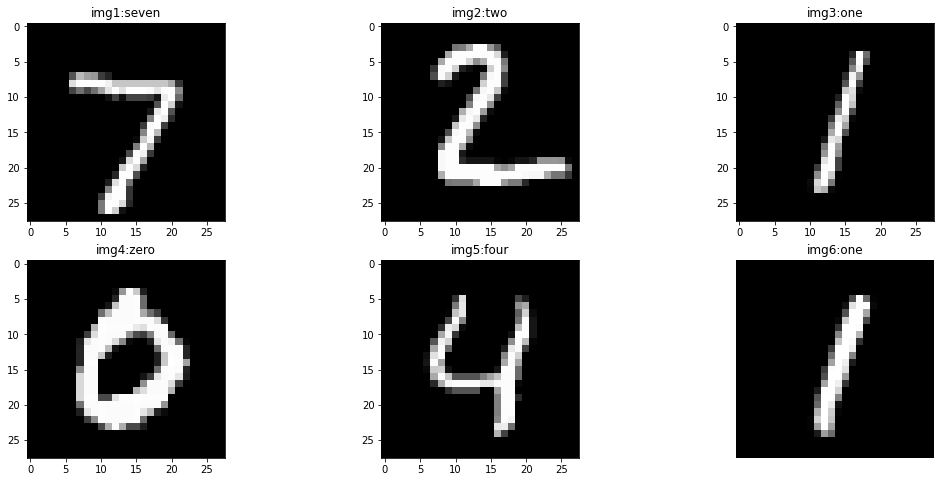

In [89]:
from tensorflow.keras.preprocessing.image import load_img

# Image titles
image_titles = ['seven', 'two', 'one','zero','four','one']

# Load images and Convert them to a Numpy array
img1 = x_test[0].reshape(28,28)
img2 = x_test[1].reshape(28,28)
img3 = x_test[2].reshape(28,28)
img4 = x_test[3].reshape(28,28)
img5 = x_test[4].reshape(28,28)
img6 = x_test[5].reshape(28,28)

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(img1, cmap='gray') 
ax.set_title('img1:'+ image_titles[0])
ax = fig.add_subplot(2, 3, 2)
ax.imshow(img2, cmap='gray') 
ax.set_title('img2:'+ image_titles[1])
ax = fig.add_subplot(2,3, 3)
ax.imshow(img3, cmap='gray') 
ax.set_title('img3:' + image_titles[2])
ax = fig.add_subplot(2,3, 4)
ax.imshow(img4, cmap='gray') 
ax.set_title('img4:' + image_titles[3])
ax = fig.add_subplot(2,3, 5)
ax.imshow(img5, cmap='gray') 
ax.set_title('img5:' + image_titles[4])
ax = fig.add_subplot(2,3, 6)
ax.imshow(img6, cmap='gray') 
ax.set_title('img6:' + image_titles[5])
ax.axis('off')
plt.show()



### GradCam

Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

https://arxiv.org/abs/1610.02391




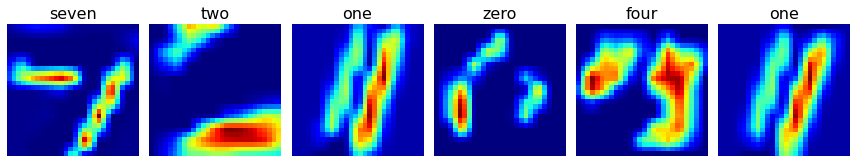

In [90]:
images = np.asarray([np.array(img1), np.array(img2), np.array(img3),np.array(img4),np.array(img5),np.array(img6)])
X = images.reshape(6,28,28,1)

score = CategoricalScore([7, 2, 1, 0, 4, 1])

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,model_modifier=model_modifier,clone=False)

# Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()


### GradCam++

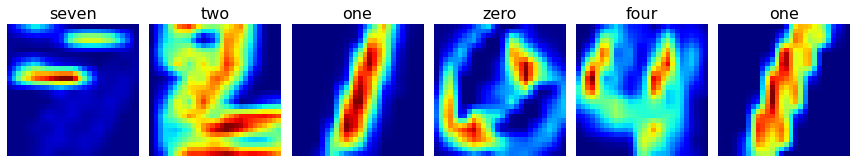

In [91]:
from tf_keras_vis.gradcam import GradcamPlusPlus

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create GradCAM++ object and repalce class name to "GradcamPlusPlus"
gradcamplus = GradcamPlusPlus(model,model_modifier,clone=False)

# Generate heatmap with GradCAM
camplus = gradcamplus(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(camplus[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()



## Recursive Feature Elimination 

Example taken from https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py

<Figure size 1296x576 with 0 Axes>

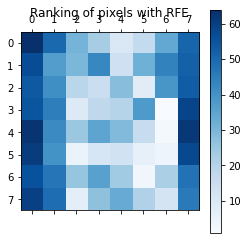

In [92]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
fig = plt.figure(figsize=(18, 8))
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()